In [46]:
!pip install pillow transformers datasets > /dev/null 2>&1
!pip install --upgrade torch torchvision torchaudio > /dev/null 2>&1

In [47]:
!python -c "import torch; print(torch.__version__)"

2.6.0+cu124


## Imports

In [48]:
import requests
import torch
from PIL import Image
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoProcessor

In [49]:
torch.cuda.is_available()

True

## Testing Pretrained iJEPA

In [50]:
model_id = "facebook/ijepa_vith14_1k"
processor = AutoProcessor.from_pretrained(model_id, use_fast=True)
model = AutoModel.from_pretrained(model_id)

In [51]:
# 1. Get the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}") # Using :, for thousands separators

# 2. Get the number of trainable parameters
# (Initially, all parameters loaded this way are trainable)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params:,}")

# 3. Print the model architecture (can be very long!)
# This shows the layers and their structure.
print("\nModel Architecture:")
print(model)
# Note: Uncomment the above lines if you want to see the full layer structure,
# but be aware it will print a lot of text for a large model like ViT-H.

# 4. Access the model's configuration
# This contains hyperparameters and configuration details used to build the model.
config = model.config
print("\nModel Configuration (Excerpt):")
# Print a few key items from the config
print(f"  Model Type: {config.model_type}")
print(f"  Hidden Size: {config.hidden_size}")
print(f"  Num Hidden Layers: {config.num_hidden_layers}")
print(f"  Num Attention Heads: {config.num_attention_heads}")
print(f"  Image Size: {config.image_size}")
print(f"  Patch Size: {config.patch_size}")
# You can print the whole config object too: print(config)

Total Parameters: 630,762,240
Trainable Parameters: 630,762,240

Model Architecture:
IJepaModel(
  (embeddings): IJepaEmbeddings(
    (patch_embeddings): IJepaPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): IJepaEncoder(
    (layer): ModuleList(
      (0-31): 32 x IJepaLayer(
        (attention): IJepaAttention(
          (attention): IJepaSelfAttention(
            (query): Linear(in_features=1280, out_features=1280, bias=True)
            (key): Linear(in_features=1280, out_features=1280, bias=True)
            (value): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (output): IJepaSelfOutput(
            (dense): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): IJepaIntermediate(
          (dense): Linear(in_features=1280, out_features=5120,

In [52]:
@torch.no_grad()
def infer(image):
    inputs = processor(image, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)


In [53]:
url_1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
url_2 = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url_2 = "http://images.cocodataset.org/val2017/000000219578.jpg"


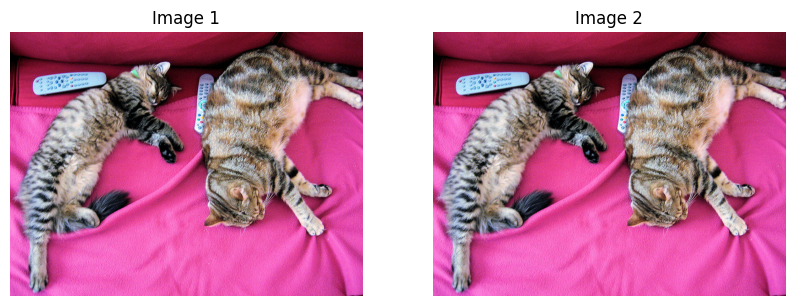

In [54]:
image_1 = Image.open(requests.get(url_1, stream=True).raw)
image_2 = Image.open(requests.get(url_2, stream=True).raw)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_1)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_2)
plt.title("Image 2")
plt.axis('off')

plt.show()

In [55]:
embed_1 = infer(image_1)
print(embed_1.shape)

torch.Size([1, 1280])


In [56]:
embed_2 = infer(image_2)
print(embed_2.shape)

torch.Size([1, 1280])


In [57]:
similarity = cosine_similarity(embed_1, embed_2)
print(similarity)

tensor([1.0000])
